In [66]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Input, Concatenate, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.optimizers import adam
from keras.utils import Sequence
from numpy.random import seed 
from tensorflow import set_random_seed 
from keras import backend as K
import tensorflow as tf


seed_n = 67
random.seed(seed_n)
os.environ['PYTHONHASHSEED'] = str(seed)
seed(seed_n)
set_random_seed(seed_n)

In [24]:
train_dir = './Unet-images/train/images'
label_dir = './Unet-images/train/label'
test_dir = './Unet-images/test'

len(glob.glob(train_dir+'/*/*'))

30

Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
image_batch_shape:  (4, 512, 512, 1)
mask_batch_shape:  (4, 512, 512, 1)


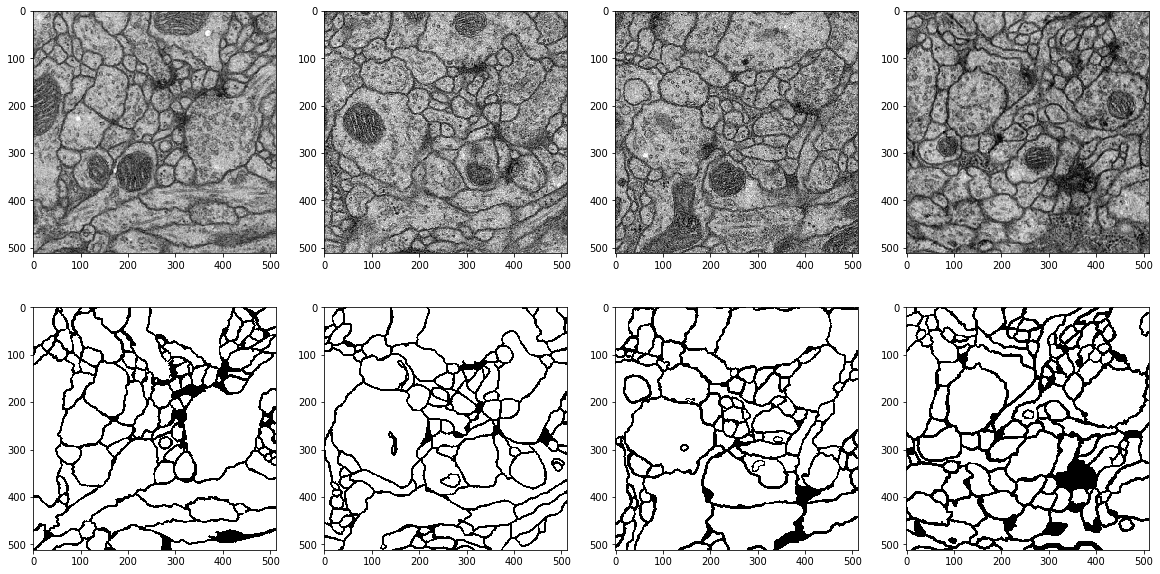

In [113]:
input_shape = (512,512)
batch_size = 4

# normalizing
Imagegen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
Imagegen_test = ImageDataGenerator(rescale=1./255)

image_datagen = Imagegen.flow_from_directory(
            train_dir,
            target_size=input_shape,
            batch_size=batch_size,
            color_mode='grayscale',
            class_mode=None,
            classes=None,
            subset='training',
            seed=seed_n
            )

mask_datagen = Imagegen.flow_from_directory(
            label_dir,
            target_size=input_shape,
            color_mode='grayscale',
            batch_size=batch_size,
            class_mode=None,
            subset='training',
            seed=seed_n
            )

image_datagen_val = Imagegen.flow_from_directory(
            train_dir,
            target_size=input_shape,
            batch_size=batch_size,
            color_mode='grayscale',
            class_mode=None,
            classes=None,
            subset='validation',
            seed=seed_n
            )

mask_datagen_val = Imagegen.flow_from_directory(
            label_dir,
            target_size=input_shape,
            color_mode='grayscale',
            batch_size=batch_size,
            class_mode=None,
            subset='validation',
            seed=seed_n
            )

test_img_datagen = Imagegen_test.flow_from_directory(
            test_dir,
            target_size=input_shape,
            color_mode='grayscale',
            batch_size=batch_size,
            class_mode=None,
            shuffle=False
            )


training_dataset = zip(image_datagen,mask_datagen)
val_dataset = zip(image_datagen_val,mask_datagen_val)

for image_batch, mask_batch in training_dataset:
    print('image_batch_shape: ', image_batch.shape)
    print('mask_batch_shape: ', mask_batch.shape)
    plt.figure(figsize=(20,10))
    for i in range(len(image_batch)):
        plt.subplot(2,4,i+1),plt.imshow(image_batch[i,:,:,0],cmap='gray')
        plt.subplot(2,4,4+(i+1)),plt.imshow(mask_batch[i,:,:,0],cmap='gray')
    break;

In [36]:
*input_shape,1

(512, 512, 1)

In [85]:
unit = 8

Input_L = Input(shape=(*input_shape,1))

conv_L1 = Conv2D(unit,(3,3),padding='same',activation='relu')(Input_L)
conv_L1 = Conv2D(unit,(3,3),padding='same',activation='relu')(conv_L1)

conv_L2 = MaxPool2D()(conv_L1)
conv_L2 = Conv2D(2*unit,(3,3),padding='same',activation='relu')(conv_L2)
conv_L2 = Conv2D(2*unit,(3,3),padding='same',activation='relu')(conv_L2)

conv_L3 = MaxPool2D()(conv_L2)
conv_L3 = Conv2D(4*unit,(3,3),padding='same',activation='relu')(conv_L3)
conv_L3 = Conv2D(4*unit,(3,3),padding='same',activation='relu')(conv_L3)

conv_L4 = MaxPool2D()(conv_L3)
conv_L4 = Conv2D(8*unit,(3,3),padding='same',activation='relu')(conv_L4)
conv_L4 = Conv2D(8*unit,(3,3),padding='same',activation='relu')(conv_L4)

conv_L5 = MaxPool2D()(conv_L4)
conv_L5 = Conv2D(16*unit,(3,3),padding='same',activation='relu')(conv_L5)
conv_L5 = Conv2D(16*unit,(3,3),padding='same',activation='relu')(conv_L5)

conv_L4u = Conv2DTranspose(8*unit,(3,3),strides=2,padding='same')(conv_L5)
conv_L4u = Concatenate()([conv_L4, conv_L4u])
conv_L4u = Conv2D(8*unit,(3,3),padding='same',activation='relu')(conv_L4u)
conv_L4u = Conv2D(8*unit,(3,3),padding='same',activation='relu')(conv_L4u)

conv_L3u = Conv2DTranspose(4*unit,(3,3),strides=2,padding='same')(conv_L4u)
conv_L3u = Concatenate()([conv_L3, conv_L3u])
conv_L3u = Conv2D(4*unit,(3,3),padding='same',activation='relu')(conv_L3u)
conv_L3u = Conv2D(4*unit,(3,3),padding='same',activation='relu')(conv_L3u)

conv_L2u = Conv2DTranspose(2*unit,(3,3),strides=2,padding='same')(conv_L3u)
conv_L2u = Concatenate()([conv_L2, conv_L2u])
conv_L2u = Conv2D(2*unit,(3,3),padding='same',activation='relu')(conv_L2u)
conv_L2u = Conv2D(2*unit,(3,3),padding='same',activation='relu')(conv_L2u)

conv_L1u = Conv2DTranspose(unit,(3,3),strides=2,padding='same')(conv_L2u)
conv_L1u = Concatenate()([conv_L1, conv_L1u])
conv_L1u = Conv2D(unit,(3,3),padding='same',activation='relu')(conv_L1u)
conv_L1u = Conv2D(unit,(3,3),padding='same',activation='relu')(conv_L1u)

Output_L = Conv2D(1,(1,1),padding='same',activation='sigmoid')(conv_L1u)

model = Model(Input_L, Output_L)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_319 (Conv2D)             (None, 512, 512, 8)  80          input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_320 (Conv2D)             (None, 512, 512, 8)  584         conv2d_319[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_97 (MaxPooling2D) (None, 256, 256, 8)  0           conv2d_320[0][0]                 
__________________________________________________________________________________________________
conv2d_321

In [86]:
def get_iou_vector(A, B,threshold = 0.5):
    
    SMOOTH = 1e-6
    batch_size = A.shape[0]
    metric = 0.0
    B = B > threshold
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)

        intersection = np.sum(t * p)
        union = true + pred - intersection

        iou = (intersection+SMOOTH) / (union+SMOOTH)       
        iou = np.floor(max(0, (iou - threshold)*20)) / 10      
        metric += iou

    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred ], tf.float64)

In [87]:
optimizer = adam(lr=0.0005)
model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = [my_iou_metric])

In [90]:
epochs = 200

model.fit_generator(training_dataset,
                    steps_per_epoch = image_datagen.samples/batch_size,
                    epochs=epochs,
                    validation_data = val_dataset,
                    validation_steps = image_datagen_val.samples/batch_size,
                    verbose = 1
                   )

Epoch 1/200
6/6 [==============================] - 3s 475ms/step - loss: 0.3226 - my_iou_metric: 0.5917 - val_loss: 0.3497 - val_my_iou_metric: 0.5833
Epoch 2/200
6/6 [==============================] - 1s 95ms/step - loss: 0.3375 - my_iou_metric: 0.5708 - val_loss: 0.3449 - val_my_iou_metric: 0.5833
Epoch 3/200
6/6 [==============================] - 1s 94ms/step - loss: 0.3149 - my_iou_metric: 0.6125 - val_loss: 0.3231 - val_my_iou_metric: 0.6000
Epoch 4/200
6/6 [==============================] - 1s 95ms/step - loss: 0.3183 - my_iou_metric: 0.6000 - val_loss: 0.3048 - val_my_iou_metric: 0.6000
Epoch 5/200
6/6 [==============================] - 1s 98ms/step - loss: 0.3029 - my_iou_metric: 0.6167 - val_loss: 0.3008 - val_my_iou_metric: 0.6000
Epoch 6/200
6/6 [==============================] - 1s 95ms/step - loss: 0.2953 - my_iou_metric: 0.6250 - val_loss: 0.2979 - val_my_iou_metric: 0.6000
Epoch 7/200
6/6 [==============================] - 1s 95ms/step - loss: 0.3083 - my_iou_metric: 0.5

6/6 [==============================] - 1s 97ms/step - loss: 0.2270 - my_iou_metric: 0.6958 - val_loss: 0.2461 - val_my_iou_metric: 0.7000
Epoch 56/200
6/6 [==============================] - 1s 100ms/step - loss: 0.2277 - my_iou_metric: 0.7000 - val_loss: 0.2603 - val_my_iou_metric: 0.6833
Epoch 57/200
6/6 [==============================] - 1s 99ms/step - loss: 0.2233 - my_iou_metric: 0.7125 - val_loss: 0.2490 - val_my_iou_metric: 0.7000
Epoch 58/200
6/6 [==============================] - 1s 99ms/step - loss: 0.2243 - my_iou_metric: 0.7167 - val_loss: 0.2484 - val_my_iou_metric: 0.7000
Epoch 59/200
6/6 [==============================] - 1s 97ms/step - loss: 0.2205 - my_iou_metric: 0.7208 - val_loss: 0.2406 - val_my_iou_metric: 0.7000
Epoch 60/200
6/6 [==============================] - 1s 99ms/step - loss: 0.2242 - my_iou_metric: 0.7292 - val_loss: 0.2386 - val_my_iou_metric: 0.7000
Epoch 61/200
6/6 [==============================] - 1s 99ms/step - loss: 0.2028 - my_iou_metric: 0.7458 - 

6/6 [==============================] - 1s 97ms/step - loss: 0.1275 - my_iou_metric: 0.8000 - val_loss: 0.3333 - val_my_iou_metric: 0.7000
Epoch 110/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1224 - my_iou_metric: 0.8000 - val_loss: 0.3528 - val_my_iou_metric: 0.7000
Epoch 111/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1245 - my_iou_metric: 0.8000 - val_loss: 0.3435 - val_my_iou_metric: 0.7000
Epoch 112/200
6/6 [==============================] - 1s 99ms/step - loss: 0.1235 - my_iou_metric: 0.8000 - val_loss: 0.3249 - val_my_iou_metric: 0.7000
Epoch 113/200
6/6 [==============================] - 1s 101ms/step - loss: 0.1239 - my_iou_metric: 0.8000 - val_loss: 0.3670 - val_my_iou_metric: 0.7000
Epoch 114/200
6/6 [==============================] - 1s 100ms/step - loss: 0.1253 - my_iou_metric: 0.8000 - val_loss: 0.3316 - val_my_iou_metric: 0.7000
Epoch 115/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1253 - my_iou_metric: 0.

Epoch 163/200
6/6 [==============================] - 1s 97ms/step - loss: 0.0863 - my_iou_metric: 0.8708 - val_loss: 0.4988 - val_my_iou_metric: 0.7000
Epoch 164/200
6/6 [==============================] - 1s 101ms/step - loss: 0.0849 - my_iou_metric: 0.8792 - val_loss: 0.4945 - val_my_iou_metric: 0.7000
Epoch 165/200
6/6 [==============================] - 1s 101ms/step - loss: 0.0878 - my_iou_metric: 0.8667 - val_loss: 0.5409 - val_my_iou_metric: 0.7000
Epoch 166/200
6/6 [==============================] - 1s 99ms/step - loss: 0.0841 - my_iou_metric: 0.8750 - val_loss: 0.4860 - val_my_iou_metric: 0.7000
Epoch 167/200
6/6 [==============================] - 1s 99ms/step - loss: 0.0882 - my_iou_metric: 0.8667 - val_loss: 0.5644 - val_my_iou_metric: 0.7000
Epoch 168/200
6/6 [==============================] - 1s 100ms/step - loss: 0.0889 - my_iou_metric: 0.8625 - val_loss: 0.4848 - val_my_iou_metric: 0.7000
Epoch 169/200
6/6 [==============================] - 1s 100ms/step - loss: 0.0884 - m

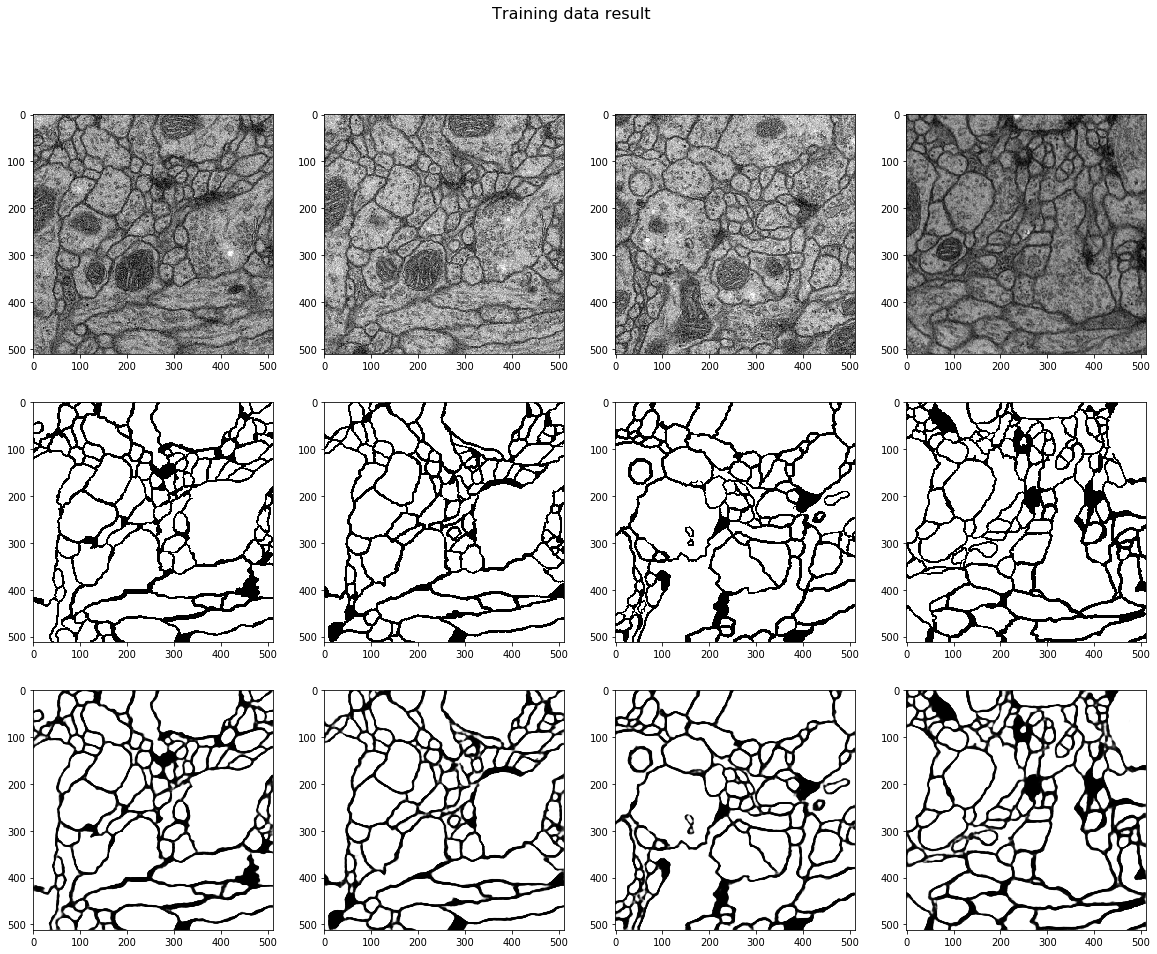

In [114]:
plt.figure(figsize=(20,15))

for image_batch, mask_batch in training_dataset:
    for i in range(len(image_batch)):
        predict = model.predict(image_batch[i].reshape(-1,512,512,1))
        plt.subplot(3,4,i+1),plt.imshow(image_batch[i,:,:,0],cmap='gray')
        plt.subplot(3,4,4+(i+1)),plt.imshow(mask_batch[i,:,:,0],cmap='gray')
        plt.subplot(3,4,8+(i+1)),plt.imshow(predict[0,:,:,0],cmap='gray')
    plt.suptitle('Training data result', fontsize=16)
    break;

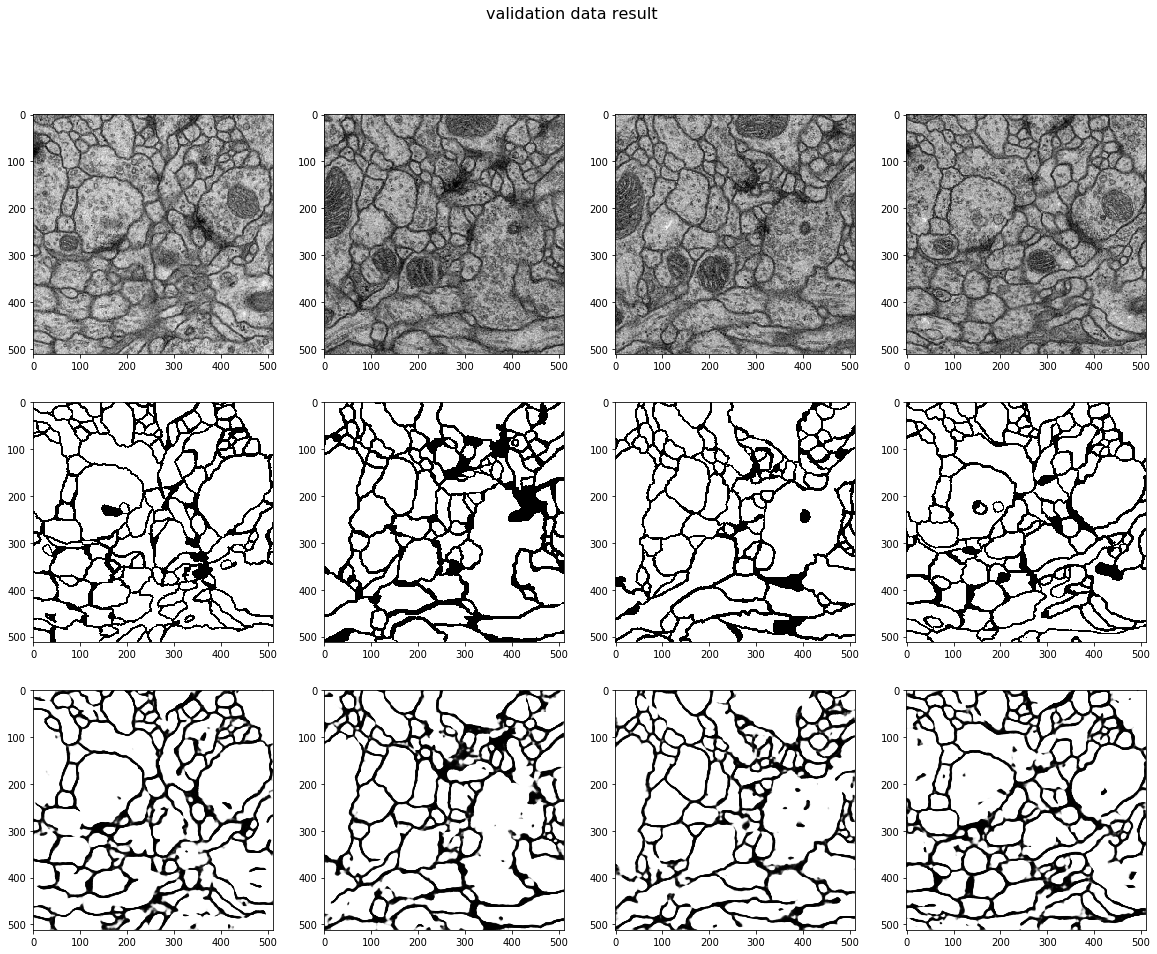

In [116]:
plt.figure(figsize=(20,15))

for image_batch, mask_batch in val_dataset:
    for i in range(len(image_batch)):
        predict = model.predict(image_batch[i].reshape(-1,512,512,1))
        plt.subplot(3,4,i+1),plt.imshow(image_batch[i,:,:,0],cmap='gray')
        plt.subplot(3,4,4+(i+1)),plt.imshow(mask_batch[i,:,:,0],cmap='gray')
        plt.subplot(3,4,8+(i+1)),plt.imshow(predict[0,:,:,0],cmap='gray')
    plt.suptitle('validation data result', fontsize=16)
    break;

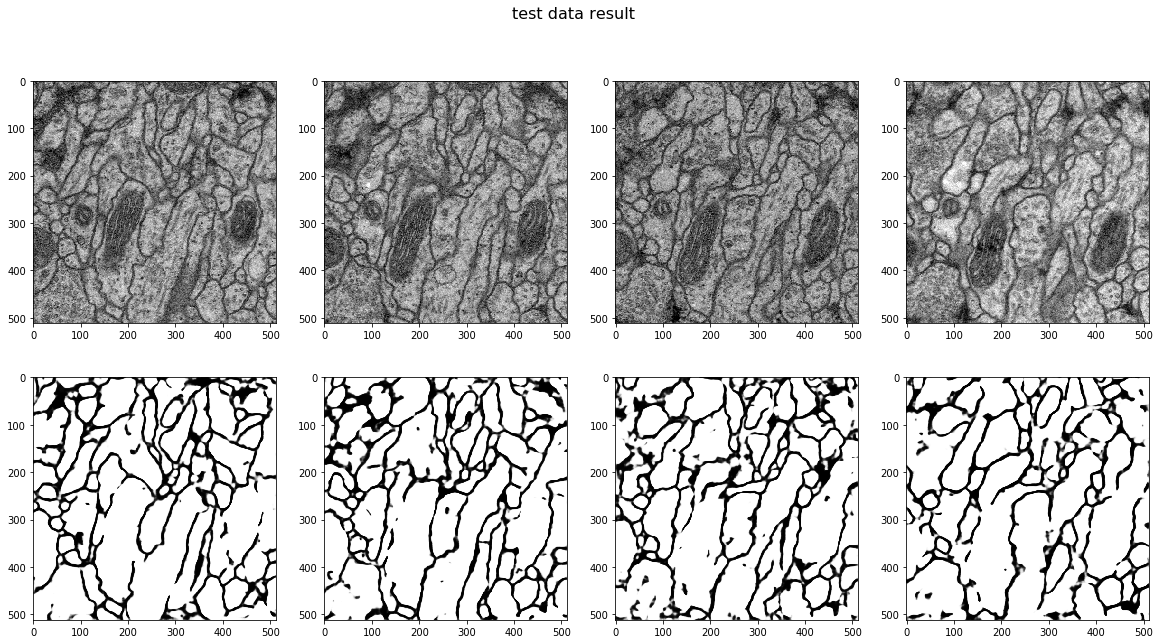

In [119]:
plt.figure(figsize=(20,10))

for image_batch in test_img_datagen:
    for i in range(len(image_batch)):
        predict = model.predict(image_batch[i].reshape(-1,512,512,1))
        plt.subplot(2,4,i+1),plt.imshow(image_batch[i,:,:,0],cmap='gray')
        plt.subplot(2,4,4+(i+1)),plt.imshow(predict[0,:,:,0],cmap='gray')
    plt.suptitle('test data result', fontsize=16)
    break;